### UKCP18 Behaviour By Model

In [1]:
import xarray
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl
import warnings

In [2]:
ids = ['UK', 'East Midlands', 'East of England',
       'East Scotland','London','North-East England',
       'North Scotland','North-West England',
       'South-East England','South-West England',
       'West Midlands','West Scotland',
       'Yorkshire and Humberside',
       'Channel Islands',
       'Isle of Man',
       'Northern Ireland','Wales']
save_ids = ['uk', 'e_mdls', 'e_eng',
       'e_scot','ldn','ne_eng',
       'n_scot','nw_eng',
       'se_eng','sw_eng',
       'w_mdls','w_scot',
       'yorks_n_hums',
       'chnl_isl',
       'isl_man',
       'n_irln','wales']

In [3]:
def earth_radius(lat):
    # From: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    lat = np.deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )

    # radius equation
    # see equation 3-107 in WGS84
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )

    return r


def area_grid(lats,lons):
    # Adapted rom: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    R = earth_radius(lats)
    dlat = np.deg2rad(np.gradient(lats, axis=0))
    dlon = np.deg2rad(np.gradient(lons, axis=1))
    dy = dlat * R
    dx = dlon * R * np.cos(np.deg2rad(lats))
    area_weights = dy * dx
    
    return area_weights

###### Building Datasets:

In [15]:
k = 1
tas_file = f'/data/met/ukcp18/{tags[k]}/dmo/tas_rcp85_ukcp18_natgb_{tags[k]}_day_19801201-20801130.nc'
tas_data  = xarray.open_dataset(tas_file, engine = "netcdf4")
tas_data.latitude.shape

(128, 108)

In [18]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
tags = ['01','04','05','06','07','08','09','10','11','12','13','15']

for i in range(len(tags)):
    print(f'Model tag: {tags[i]}')
    tas_file = f'/data/met/ukcp18/{tags[i]}/dmo/tas_rcp85_ukcp18_natgb_{tags[i]}_day_19801201-20801130.nc'
    tas_data  = xarray.open_dataset(tas_file, engine = "netcdf4")
    hurs_file = f'/data/met/ukcp18/{tags[i]}/dmo/hurs_rcp85_ukcp18_natgb_{tags[i]}_day_19801201-20801130.nc'
    hurs_data  = xarray.open_dataset(hurs_file, engine = "netcdf4")
    wind_file = f'/data/met/ukcp18/{tags[i]}/dmo/sfcWind_rcp85_ukcp18_natgb_{tags[i]}_day_19801201-20801130.nc'
    wind_data  = xarray.open_dataset(wind_file, engine = "netcdf4")
    pr_file = f'/data/met/ukcp18/{tags[i]}/dmo/pr_rcp85_ukcp18_natgb_{tags[i]}_day_19801201-20801130.nc'
    pr_data  = xarray.open_dataset(pr_file, engine = "netcdf4")
    
    
    temperature = np.array(tas_data.tas[:,:,:,0])
    r_hum       = np.array(hurs_data.hurs[:,:,:,0])
    wind        = np.array(wind_data.sfcWind[:,:,:,0]*3.6)
    rain        = np.array(pr_data.pr[:,:,:,0])
    
    years = np.vectorize(lambda x: x.year)(np.array(hurs_data.time))
    months = np.vectorize(lambda x: x.month)(np.array(hurs_data.time))
    
    del hurs_data,wind_data,pr_data
    try:
        lats = np.array(tas_data.latitude)
        lons = np.array(tas_data.longitude)
    except:
        lats = np.array(tas_data.lat)
        lons = np.array(tas_data.lon)
    lons = np.where(lons < 180, lons, lons-360)
    weights = area_grid(lats,lons)/np.mean(area_grid(lats,lons))
    
    j = 0

    # Masking data:
    if j == 0:
        mask = np.logical_not(region_mask == 0).astype(int)
        mask = mask*weights
    else:
        mask = (region_mask == j).astype(int)
        mask = mask*weights

    masked_temp = np.einsum('ijk,jk->ijk', temperature, mask)
    masked_temp[masked_temp == 0] = np.nan
    masked_rhum = np.einsum('ijk,jk->ijk', r_hum, mask)
    masked_rhum[masked_rhum == 0] = np.nan
    masked_wind = np.einsum('ijk,jk->ijk', wind, mask)
    masked_wind[masked_wind == 0] = np.nan
    masked_rain = np.einsum('ijk,jk->ijk', rain, mask)
    masked_rain[masked_rain == 0] = np.nan

    tas_arr  = []
    hurs_arr = []
    wind_arr = []
    pr_arr   = []

    for k in range(1981,2081,1): # years
        year_inds = np.where(years == k)
        summer_inds=np.concatenate((np.where(months == 6)[0],
                                    np.where(months == 7)[0],
                                    np.where(months == 8)[0]),
                                    axis = 0)
        inds = np.intersect1d(year_inds,summer_inds)
        del year_inds,summer_inds

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            tas_arr = np.append(tas_arr,np.nanmean(masked_temp[inds,:,:]))
            hurs_arr = np.append(hurs_arr,np.nanmean(masked_rhum[inds,:,:]))
            wind_arr = np.append(wind_arr,np.nanmean(masked_wind[inds,:,:]))
            pr_arr = np.append(pr_arr,np.nanmean(masked_rain[inds,:,:])) 


    np.save(f'/home/theo/outdata/1.5.outdata/tas_model_{i+1}_region_{j}_summer', tas_arr)
    np.save(f'/home/theo/outdata/1.5.outdata/hurs_model_{i+1}_region_{j}_summer', hurs_arr)
    np.save(f'/home/theo/outdata/1.5.outdata/wind_model_{i+1}_region_{j}_summer', wind_arr)
    np.save(f'/home/theo/outdata/1.5.outdata/pr_model_{i+1}_region_{j}_summer', pr_arr)

    del mask,masked_temp,masked_rhum,masked_wind,masked_rain,tas_arr,hurs_arr,wind_arr,pr_arr
    del temperature,rain,wind,r_hum,years,months,tas_data


Model tag: 01
Model tag: 04
Model tag: 05
Model tag: 06
Model tag: 07
Model tag: 08
Model tag: 09
Model tag: 10
Model tag: 11
Model tag: 12
Model tag: 13
Model tag: 15


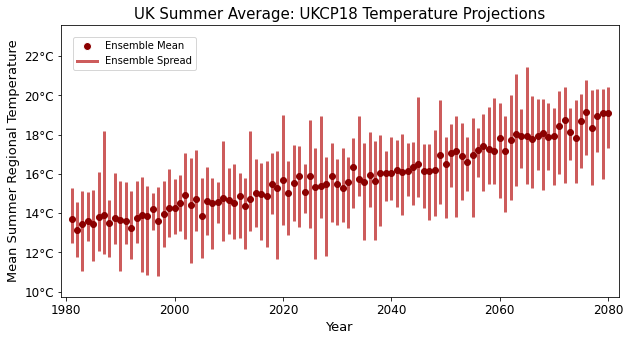

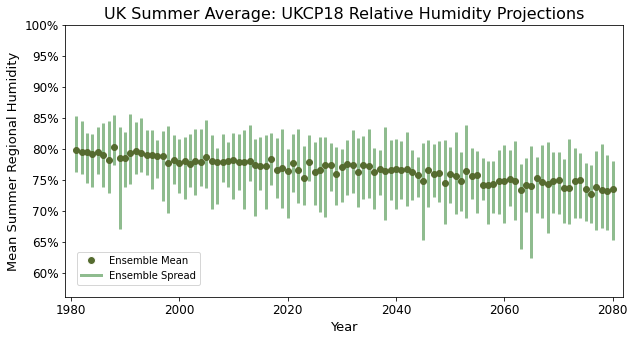

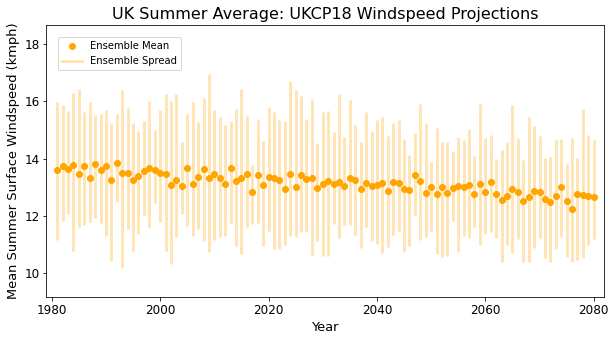

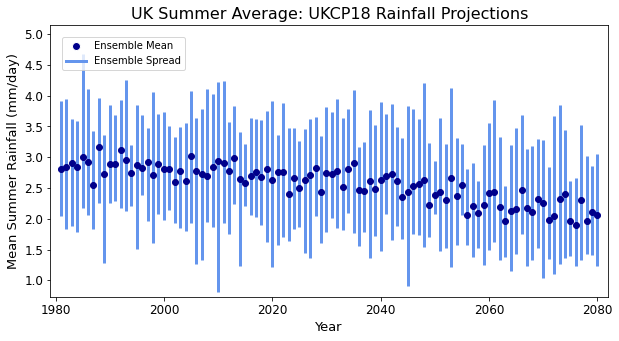

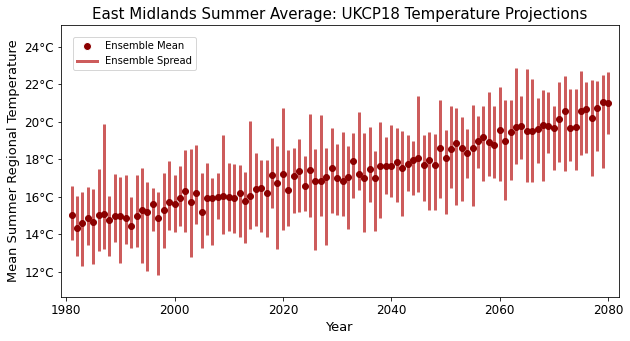

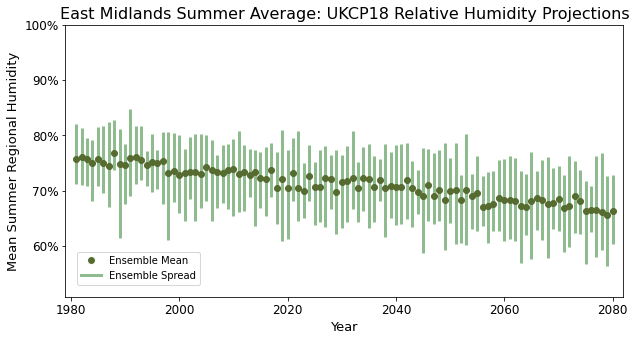

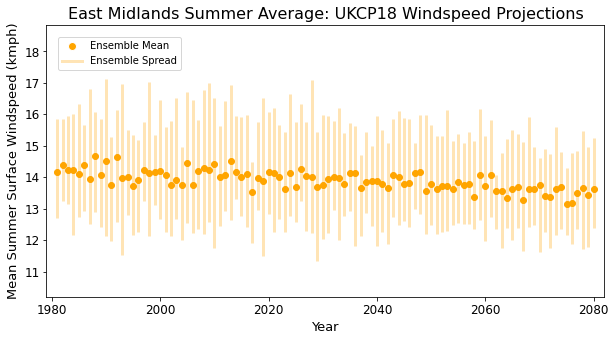

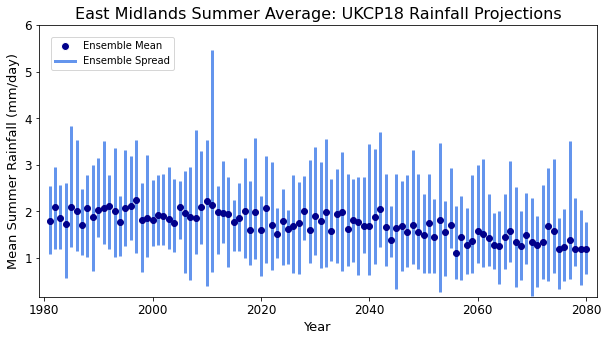

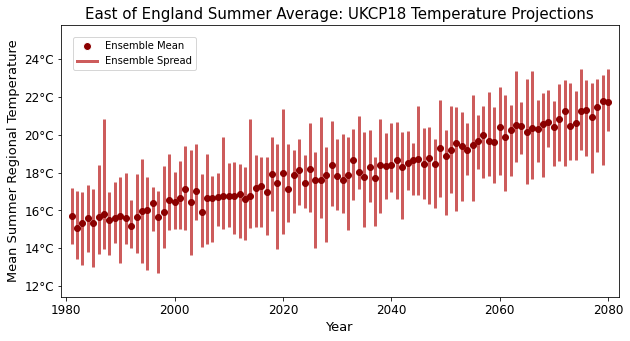

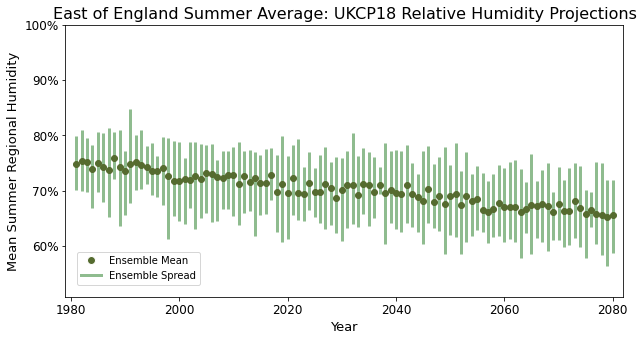

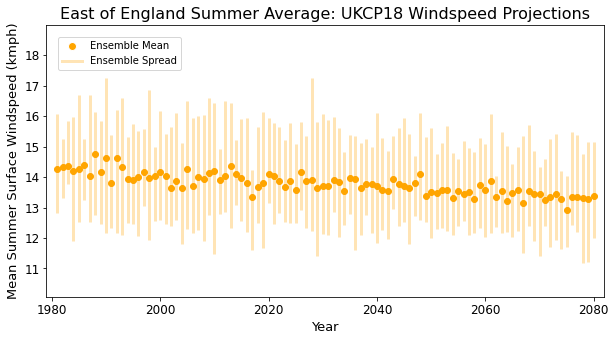

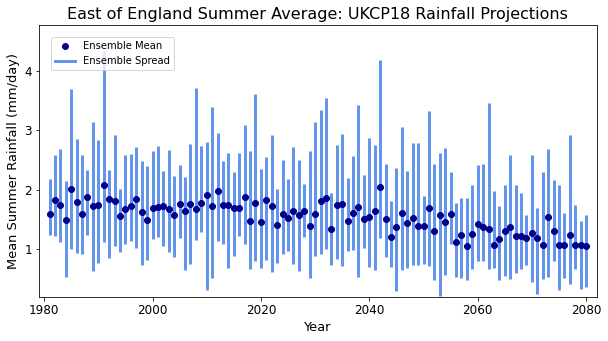

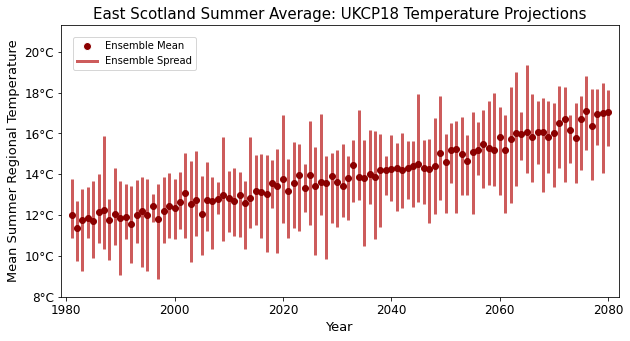

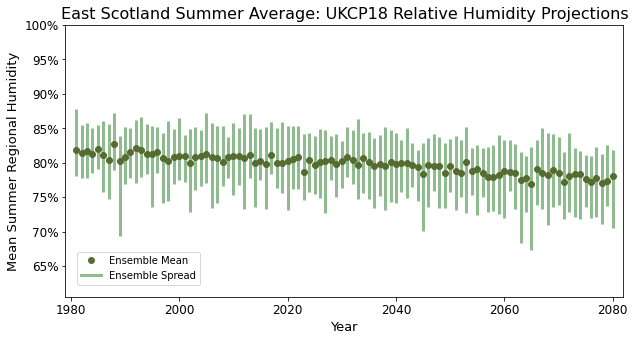

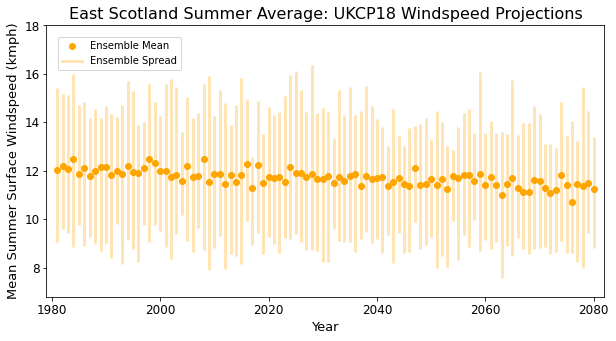

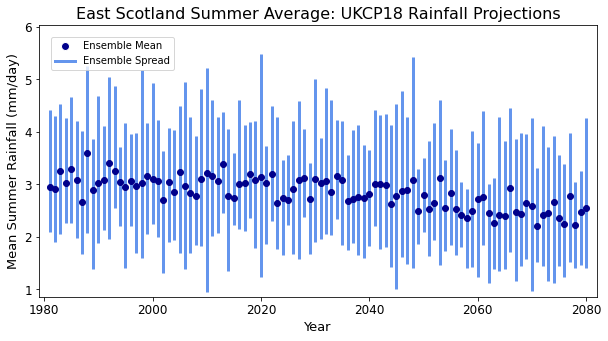

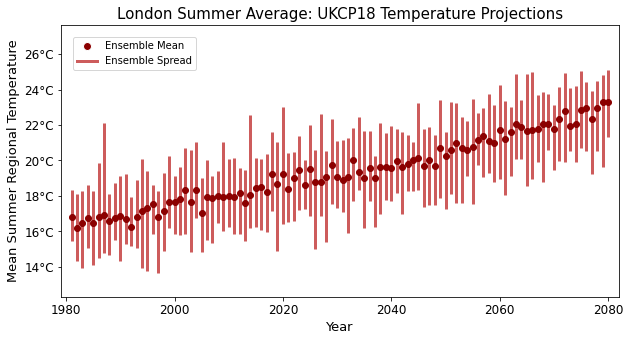

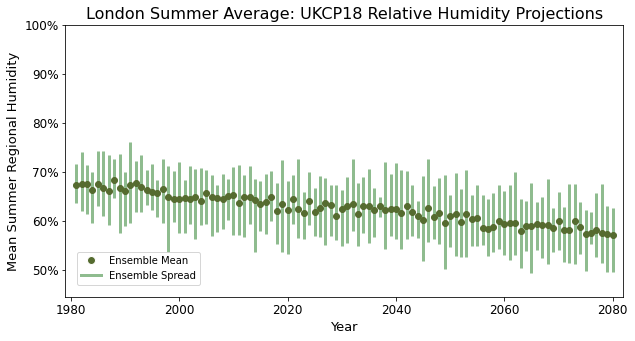

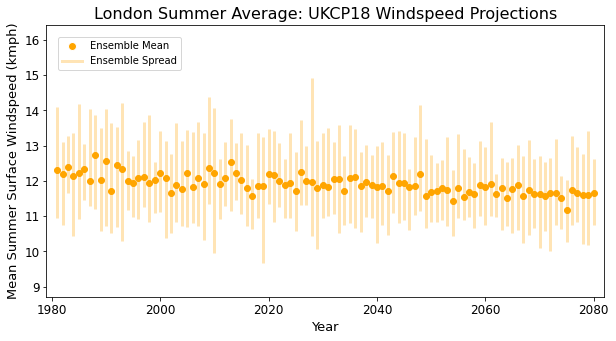

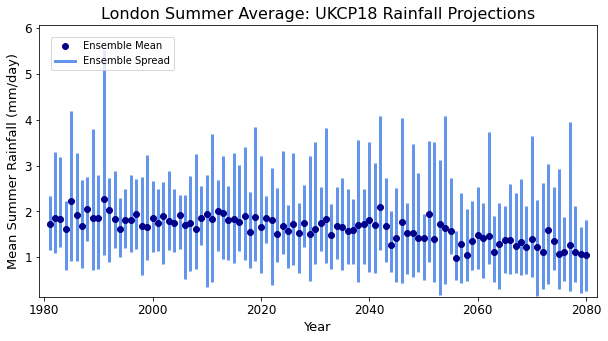

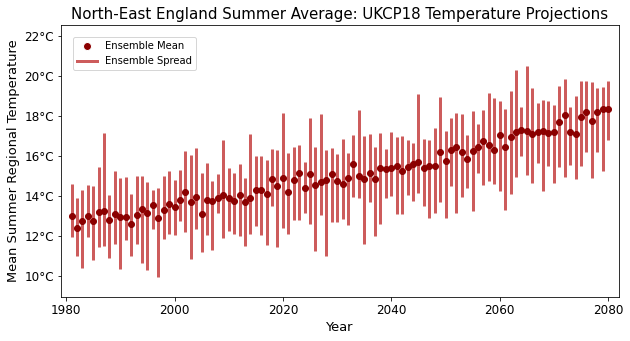

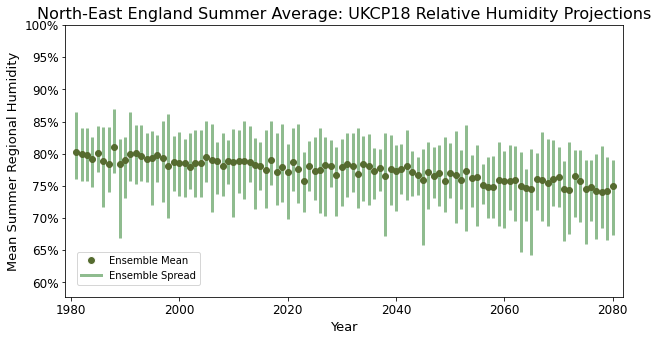

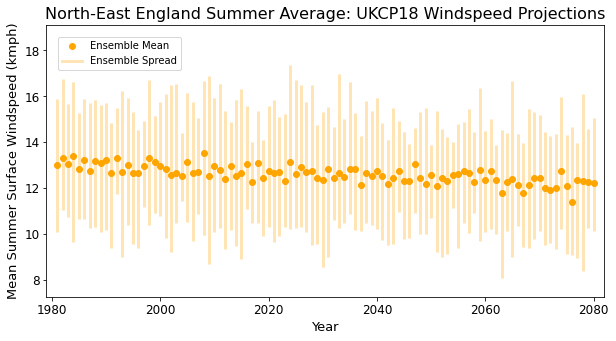

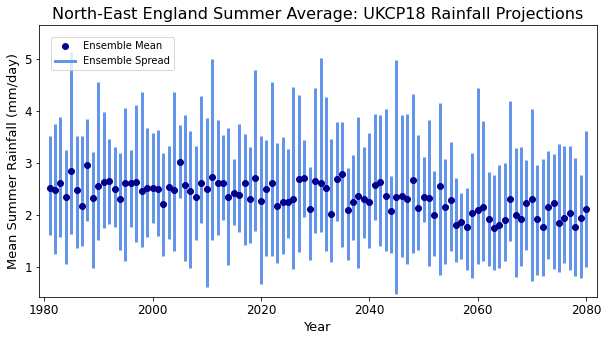

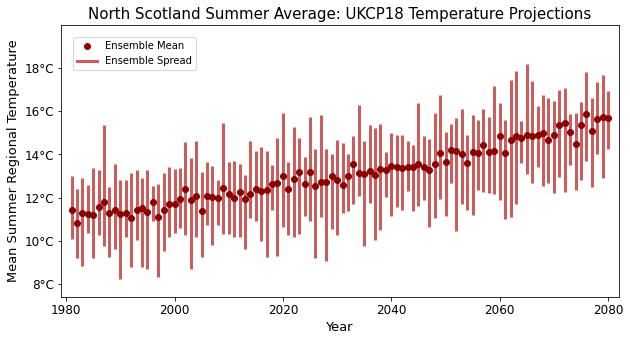

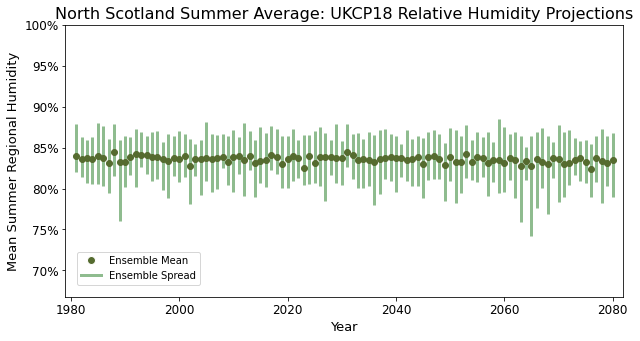

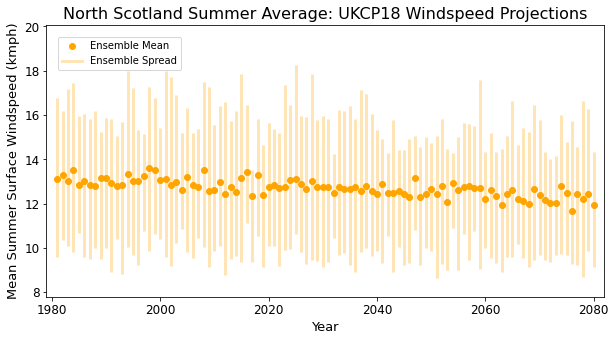

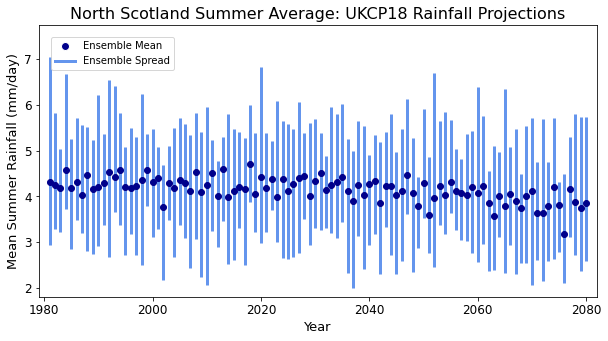

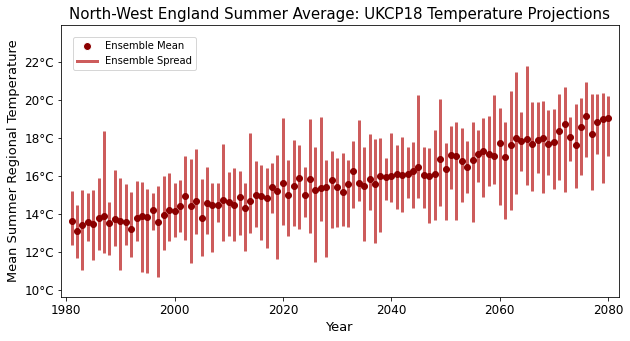

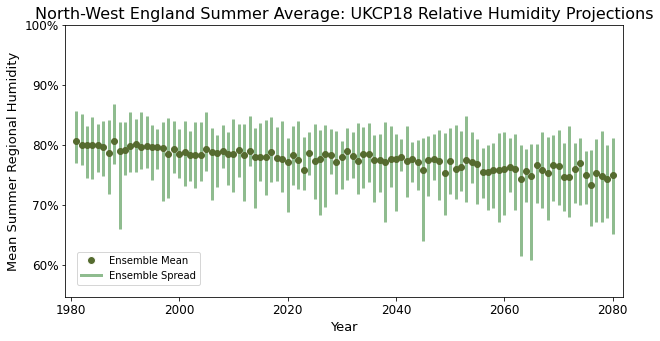

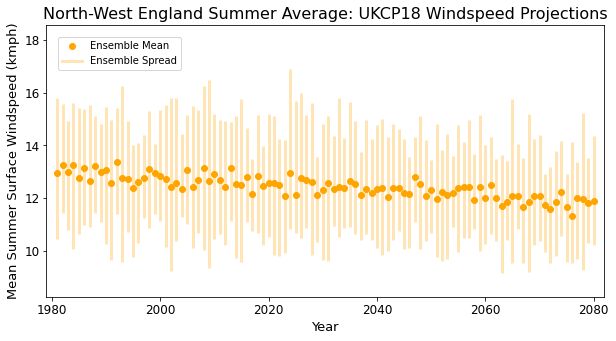

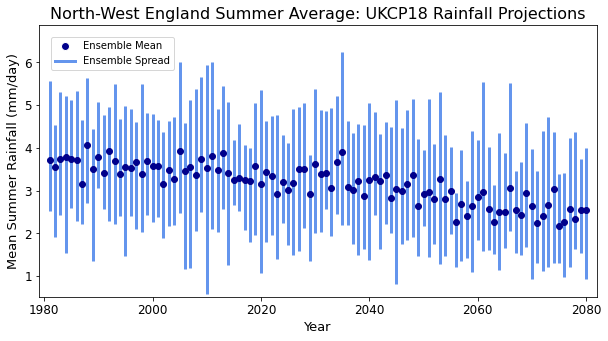

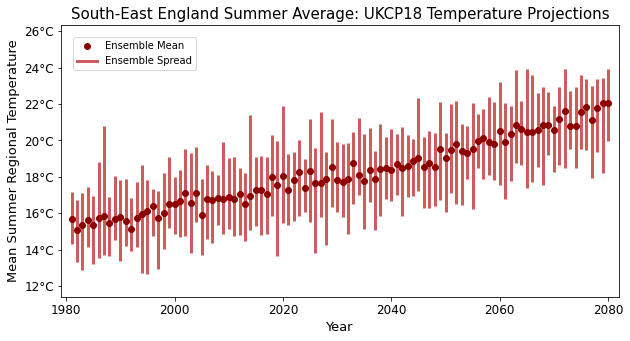

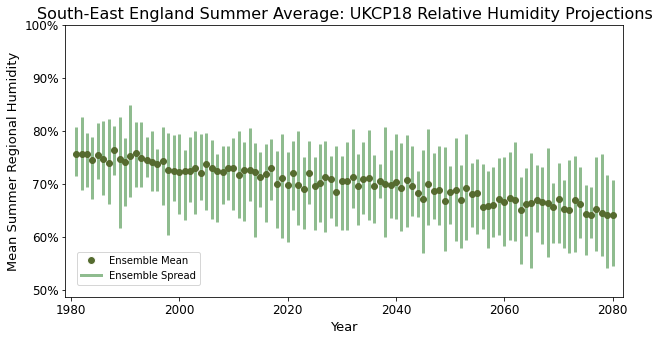

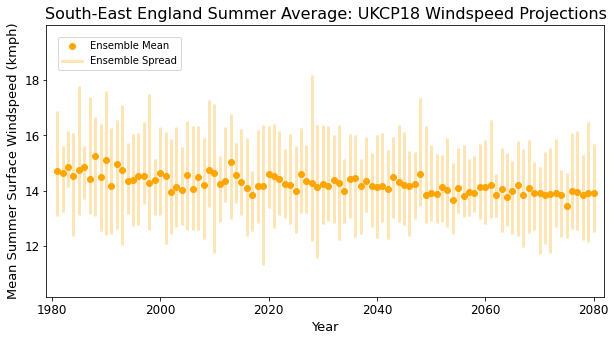

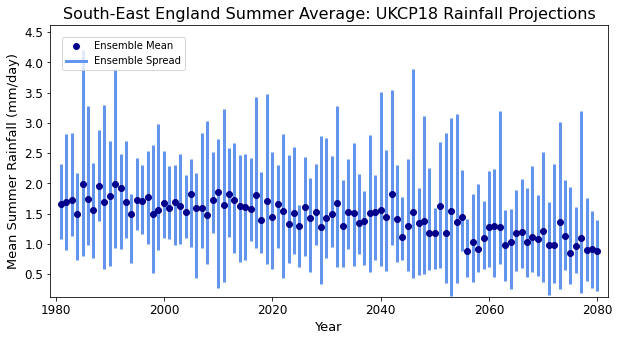

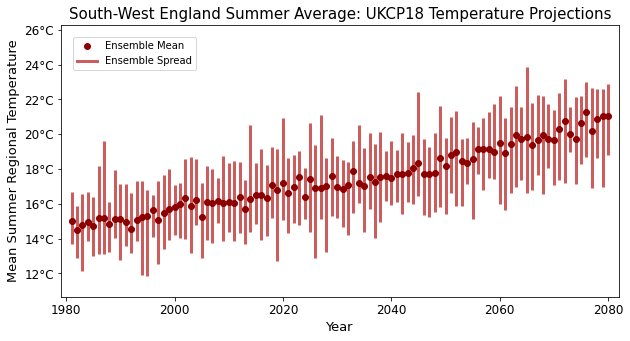

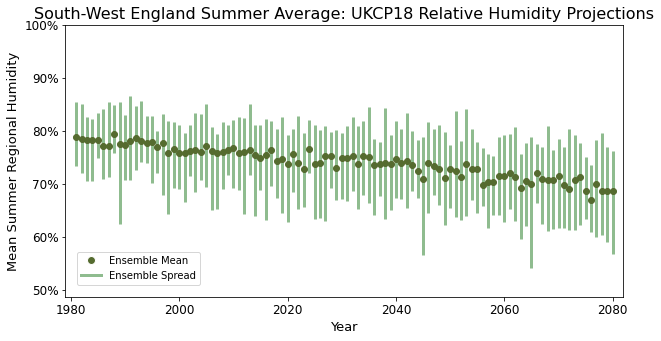

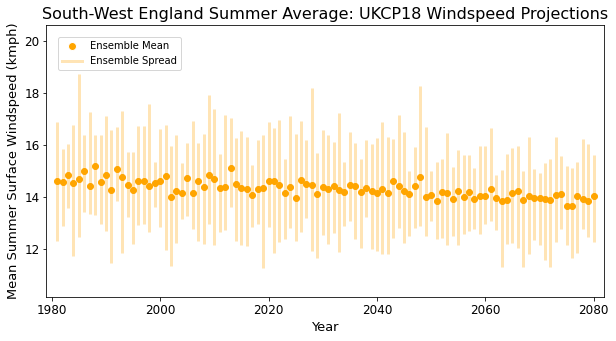

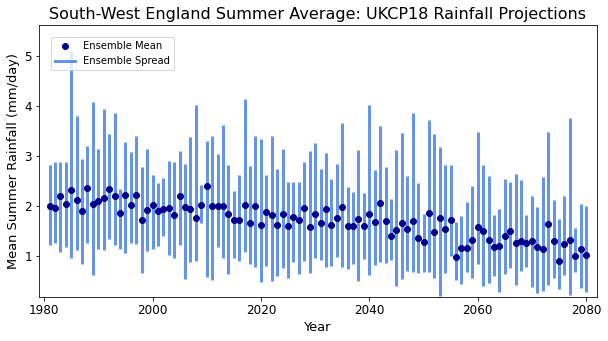

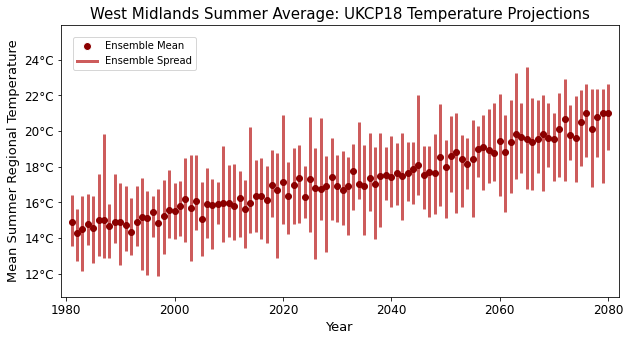

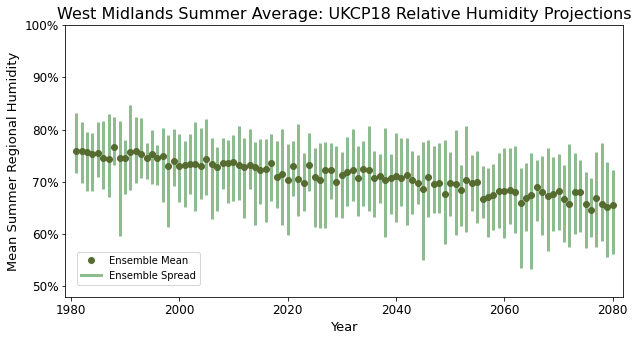

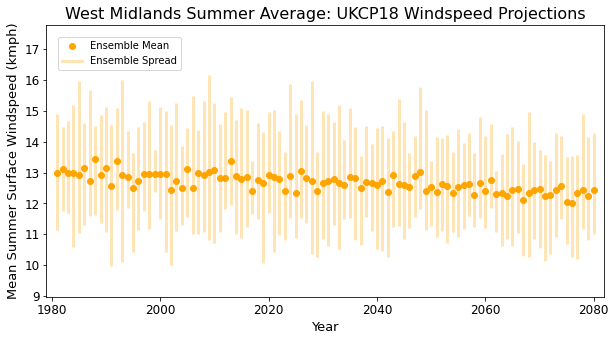

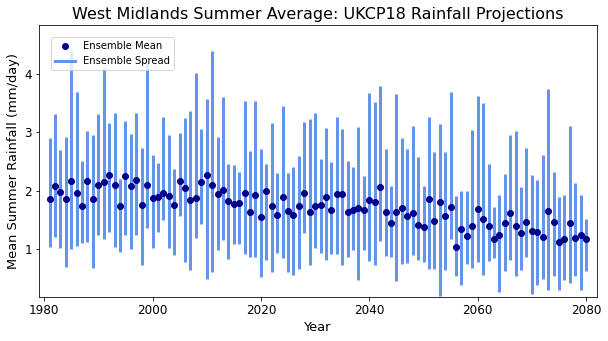

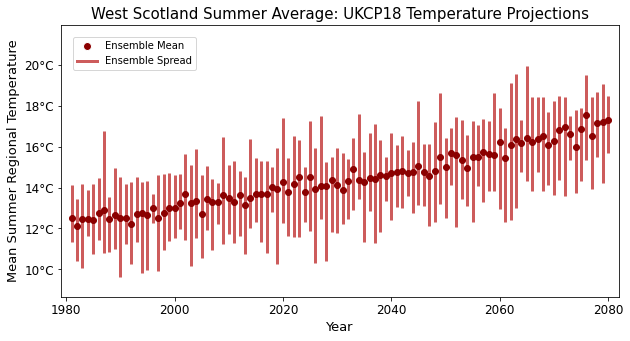

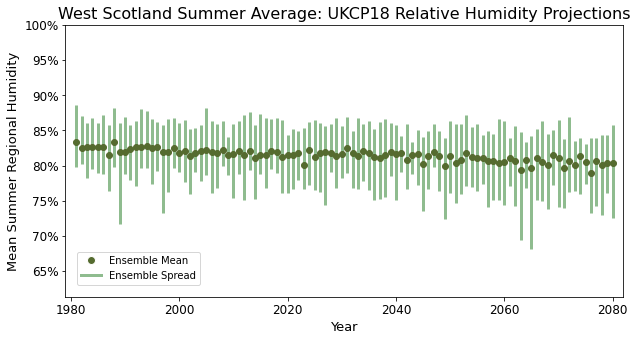

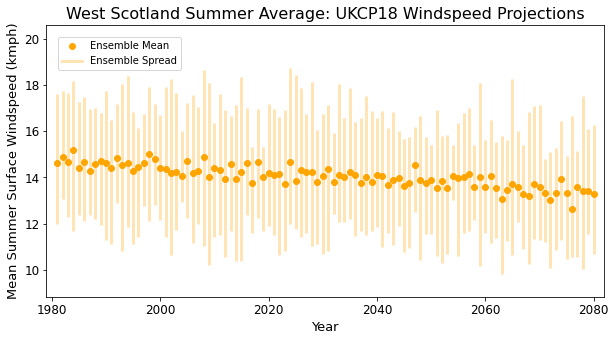

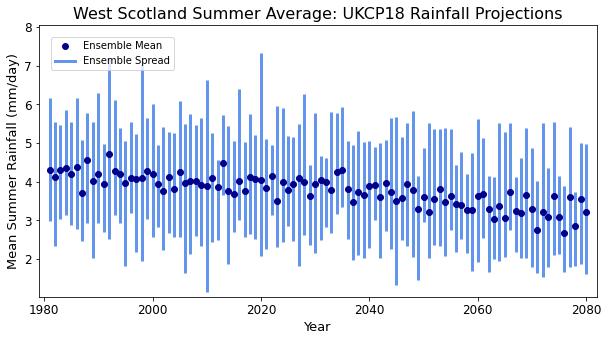

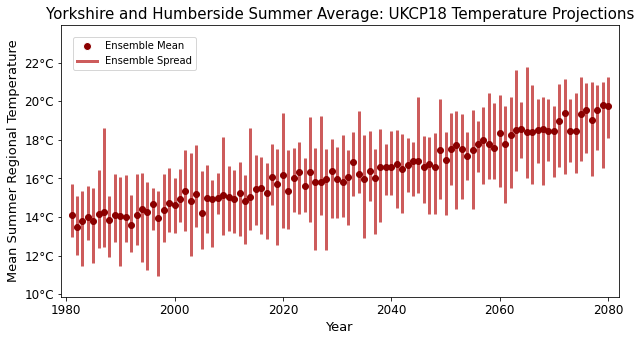

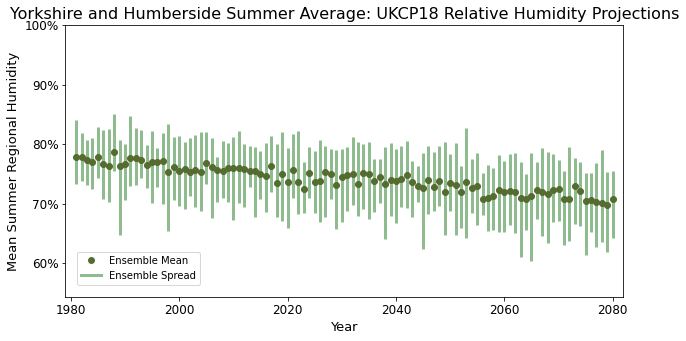

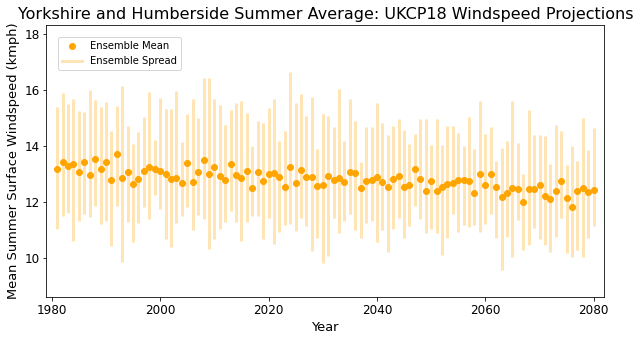

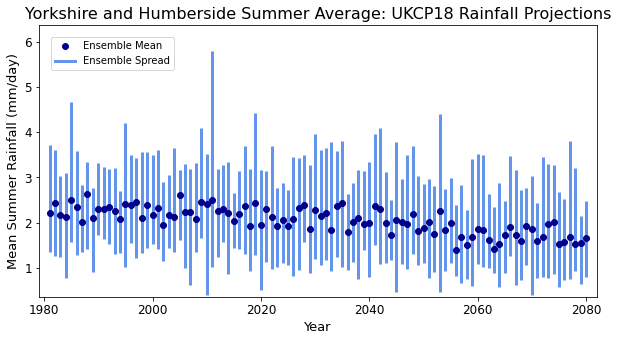

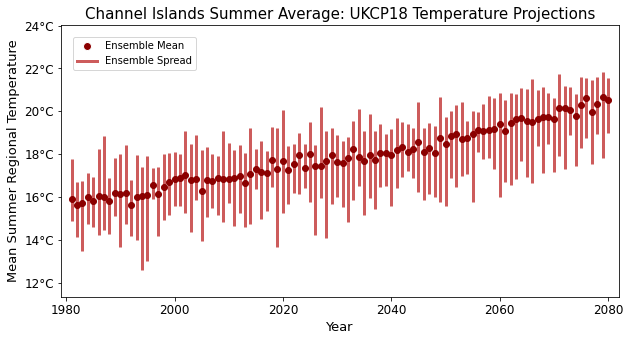

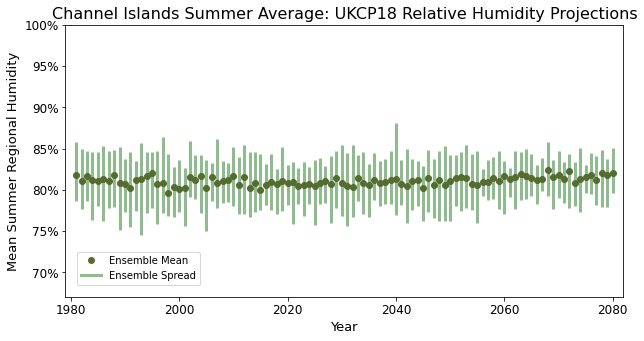

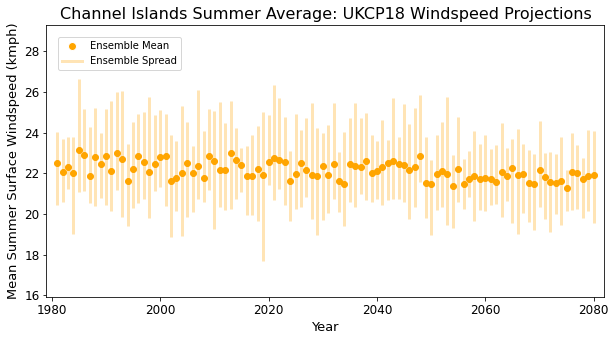

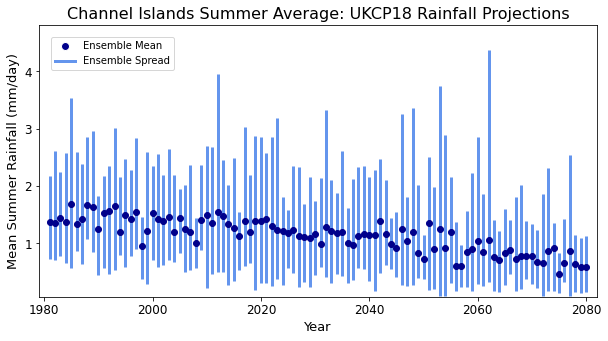

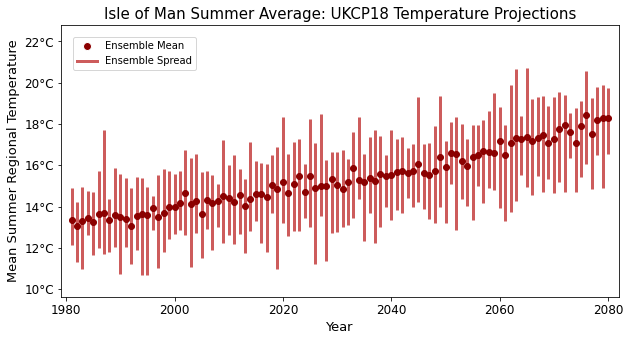

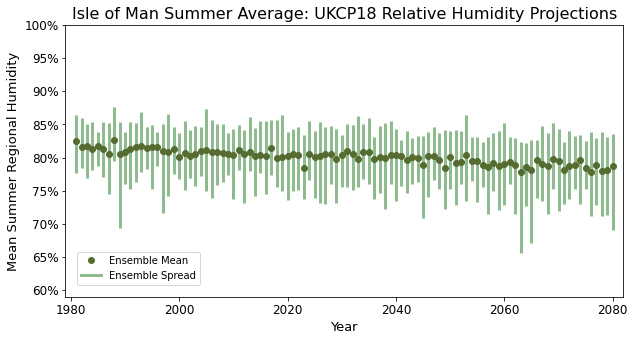

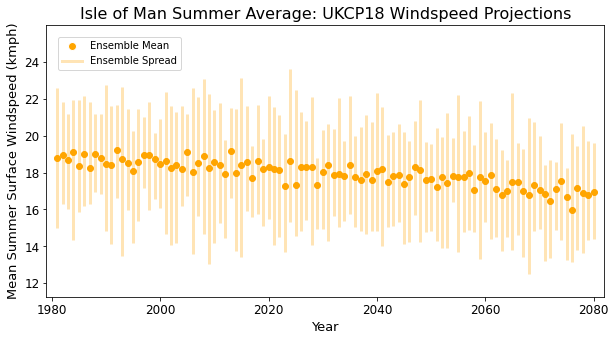

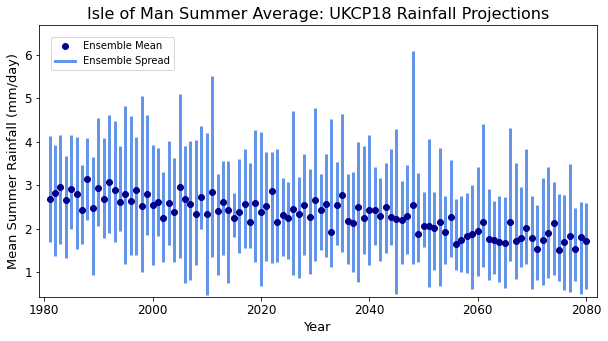

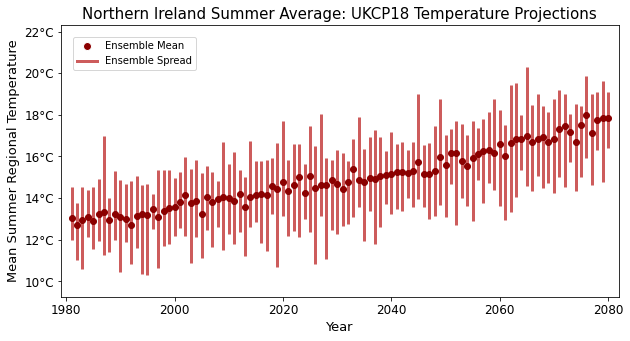

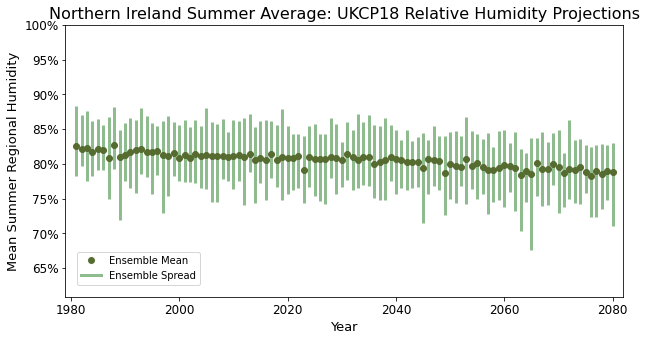

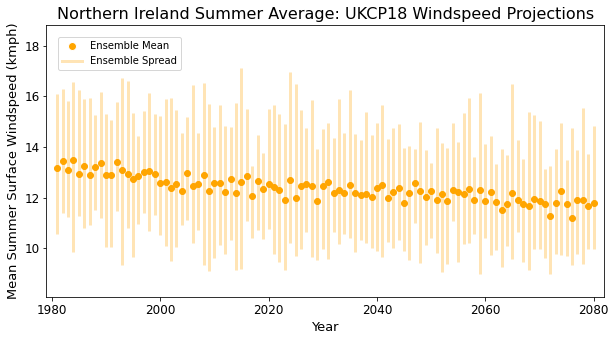

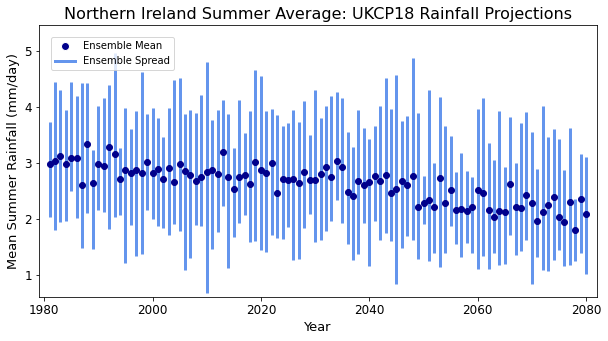

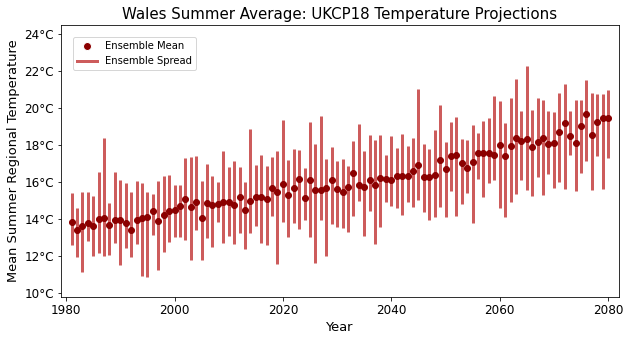

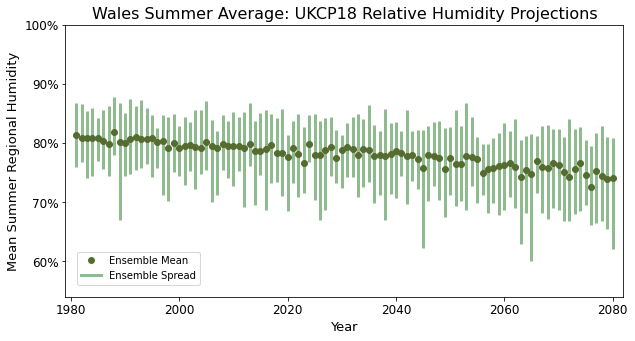

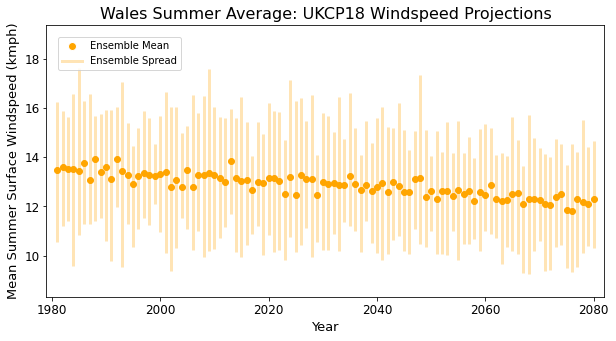

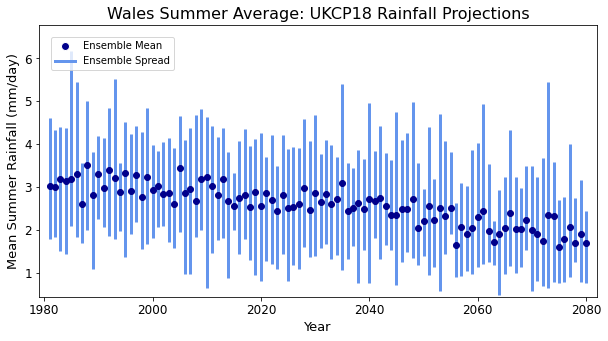

In [6]:
for j in range(17):
    # Loading data:
    tas_file_names = [f'/home/theo/outdata/1.5.outdata/tas_model_{i+1}_region_{j}_summer.npy' for i in range(12)]
    tas_data = np.array([np.load(fname) for fname in tas_file_names])
    
    hurs_file_names = [f'/home/theo/outdata/1.5.outdata/hurs_model_{i+1}_region_{j}_summer.npy' for i in range(12)]
    hurs_data = np.array([np.load(fname) for fname in hurs_file_names])
    
    wind_file_names = [f'/home/theo/outdata/1.5.outdata/wind_model_{i+1}_region_{j}_summer.npy' for i in range(12)]
    wind_data = np.array([np.load(fname) for fname in wind_file_names])
    
    pr_file_names = [f'/home/theo/outdata/1.5.outdata/pr_model_{i+1}_region_{j}_summer.npy' for i in range(12)]
    pr_data = np.array([np.load(fname) for fname in pr_file_names])
    
    # Making dates:
    dates = np.array([1981 + i for i in range(100)])
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    
        # Plotting Temperature:
        plt.figure(figsize=(10, 5))
        plt.errorbar(dates, np.nanmean(tas_data,axis = 0), 
                     yerr=np.stack((np.nanmean(tas_data,axis = 0) - np.nanmin(tas_data,axis = 0),
                                    np.nanmax(tas_data,axis = 0) - np.nanmean(tas_data,axis = 0))), 
                     fmt='o', color='darkred', ecolor='indianred', 
                     elinewidth=3, capsize=0)
        plt.title(f'{ids[j]} Summer Average: UKCP18 Temperature Projections',fontsize=15)
        handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='darkred', markersize=8),
                   mpl.lines.Line2D([0], [0], color='indianred', linewidth=3, linestyle='-')]
        plt.legend(handles,['Ensemble Mean','Ensemble Spread'],loc=2,borderaxespad=1.2)
        plt.xlabel('Year',fontsize=13)
        plt.ylabel('Mean Summer Regional Temperature',fontsize=13)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.margins(x=0.02)
        plt.ylim(0.9*np.min(tas_data),1.1*np.max(tas_data))
        plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
        plt.savefig(f'/home/theo/final_images/1.5.images/summer_tas_mean_{save_ids[j]}')
        
        # Plotting Relative Humidity:
        plt.figure(figsize=(10, 5))
        plt.errorbar(dates, np.nanmean(hurs_data,axis = 0), 
                     yerr=np.stack((np.nanmean(hurs_data,axis = 0) - np.nanmin(hurs_data,axis = 0),
                                    np.nanmax(hurs_data,axis = 0) - np.nanmean(hurs_data,axis = 0))), 
                     fmt='o', color='darkolivegreen', ecolor='darkseagreen', 
                     elinewidth=3, capsize=0)
        plt.title(f'{ids[j]} Summer Average: UKCP18 Relative Humidity Projections',fontsize=16)
        handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='darkolivegreen', markersize=8),
                   mpl.lines.Line2D([0], [0], color='darkseagreen', linewidth=3, linestyle='-')]
        plt.legend(handles,['Ensemble Mean','Ensemble Spread'],loc=3,borderaxespad=1.2)
        plt.xlabel('Year',fontsize=13)
        plt.ylabel('Mean Summer Regional Humidity',fontsize=13)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.margins(x=0.02) 
        plt.ylim(0.9*np.min(hurs_data),100)
        plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
        plt.savefig(f'/home/theo/final_images/1.5.images/summer_hurs_mean_{save_ids[j]}')
        
        # Plotting Wind:
        plt.figure(figsize=(10, 5))
        plt.errorbar(dates, np.nanmean(wind_data,axis = 0), 
                     yerr=np.stack((np.nanmean(wind_data,axis = 0) - np.nanmin(wind_data,axis = 0),
                                    np.nanmax(wind_data,axis = 0) - np.nanmean(wind_data,axis = 0))), 
                     fmt='o', color='orange', ecolor='moccasin', 
                     elinewidth=3, capsize=0)
        plt.title(f'{ids[j]} Summer Average: UKCP18 Windspeed Projections',fontsize=16)
        handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='orange', markersize=8),
                   mpl.lines.Line2D([0], [0], color='moccasin', linewidth=3, linestyle='-')]
        plt.legend(handles,['Ensemble Mean','Ensemble Spread'],loc=2,borderaxespad=1.2)
        plt.xlabel('Year',fontsize=13)
        plt.ylabel('Mean Summer Surface Windspeed (kmph)',fontsize=13)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.margins(x=0.02)      
        plt.ylim(0.9*np.min(wind_data),1.1*np.max(wind_data))
        plt.savefig(f'/home/theo/final_images/1.5.images/summer_wind_mean_{save_ids[j]}')
        
        # Plotting Rainfall:
        plt.figure(figsize=(10, 5))
        plt.errorbar(dates, np.nanmean(pr_data,axis = 0), 
                     yerr=np.stack((np.nanmean(pr_data,axis = 0) - np.nanmin(pr_data,axis = 0),
                                    np.nanmax(pr_data,axis = 0) - np.nanmean(pr_data,axis = 0))), 
                     fmt='o', color='darkblue', ecolor='cornflowerblue', 
                     elinewidth=3, capsize=0)
        plt.title(f'{ids[j]} Summer Average: UKCP18 Rainfall Projections',fontsize=16)
        handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='darkblue', markersize=8),
                   mpl.lines.Line2D([0], [0], color='cornflowerblue', linewidth=3, linestyle='-')]
        plt.legend(handles,['Ensemble Mean','Ensemble Spread'],loc=2,borderaxespad=1.2)
        plt.xlabel('Year',fontsize=13)
        plt.ylabel('Mean Summer Rainfall (mm/day)',fontsize=13)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.margins(x=0.02)      
        plt.ylim(0.9*np.min(pr_data),1.1*np.max(pr_data))
        plt.savefig(f'/home/theo/final_images/1.5.images/summer_pr_mean_{save_ids[j]}')